# Unpack Hub Clustering
#### Developed by Job de Vogel, Lisa-Marie Mueller and Jirri van den Bos

This project was developed for the course AR3B012 CORE, TU Delft. The goal of the 'Unpack' module is solving a Facility Location Problem, specifically finding the ideal number of hubs placed in a city, with their locations, considering all inhabitants of the city, based on user prefered weights.

The project has been tested on the Windows operating system. We do not guarantee this code working on other types of operating systems.

Altough thoroughly tested, we do not recommend using this project in commercial context. It has been developed for educational purposes only.

To be able to run this code efficiently, we recommend the following hardware:
- 16 GB or RAM;
- 6 core CPU (more is better);
- Good internet connection for data retrieval.

In [1]:
# Inport the package developed by UNPACK
import unpack
import random

# * Temp:
from collections import OrderedDict
import sys

In [2]:
## Initialize variables
name = 'Delft_center_walk'
data_folder = 'data/'
vehicle_type = 'walk' # walk, bike, drive, all (See osmnx documentation)
coordinates = [52.018347, 52.005217, 4.369142, 4.350504]
# Full Delft: coordinates =  [52.018347, 52.005217, 4.369142, 4.350504]

## GENERATE NETWORK
Generate a new network using the functions in the CityNetwork class. If a network already has been generated and stored in the data folder, 
please continue with 'Prepare Network'!

In [3]:
# Initialize CityNetwork object [N, S, E, W]
City = unpack.CityNetwork(name, coordinates, vehicle_type)

In [4]:
# Load osm from local or online file
# If sever does not respond, please try again in 30 seconds
City.load_osm_graph(data_folder + name + '.osm')
City.load_building_addr(data_folder + name + '_building_addresses.csv', 
    data_folder + name + '_buildings.csv', 
    data_folder + name + '_addresses.csv',
    data_folder +'runtime/'+ name + '_cbs.xml')

print('Loading finished.')

Loading street network...
Finished loading
Loading buildings...
Finished adding EPSG:3857 coordinates
Assigning buildings to CBS buurt
Checking if a building is inside a buurt
2183 / 2183
Adding the CBS data to the dataframe
2183 / 2183
Loading finished.


In [5]:
# Add speeds, lengths and distances to graph
# Overwrite speed by using overwrite_bike=16
# Further types available: overwrite_walk and overwrite_epv
City.add_rel_attributes(overwrite_bike=16, overwrite_walk=5)

In [6]:
# Project graph to the correct coordinate system
City.project_graph()

In [7]:
# (Optional) assign an 'experience' weight to the graph
# Experience can be added based on street names or coordinates
latitude = 52.005831
longitude = 4.371026

City.add_street_experience(['Oude Delft'], [10])
# City.add_coord_experience([(latitude, longitude)], [10])

In [8]:
# Calculate dataframes of nodes and edges
City.convert_graph_edges_to_df()
City.convert_graph_nodes_to_df()

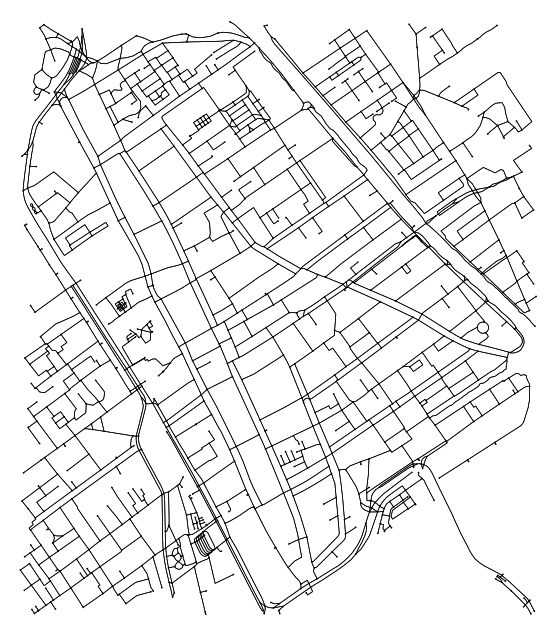

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [9]:
# (Optional) Plot the network
destinations = City.get_yx_destinations()
City.plot(destinations=destinations, show=True)

In [10]:
# (Optional) Save Pickle file of CityNetwork object
City.save_graph(name, data_folder)

Saving Delft_center_walk to data/Delft_center_walk.pkl


## Prepare Network
Load the CityNetwork object if it already has been initialized in a .pkl file.

In [3]:
# Load the CityNetwork
City = unpack.CityNetwork.load_graph(name, data_folder)

Loading...
path data/Delft_center_walk.pkl
file <_io.BufferedReader name='data/Delft_center_walk.pkl'>
opened
Loaded Delft_center_walk to object...


## Compute Nearest Edges
To be able to compute shortest paths and clusters in the network, the nearest edges in the graph for each house have to be known. Therefore a multicore nearest edge algorithm has been developed.

Computing nearest edges may have a considerable computation time. Therefore it is recommended to run the computation once, and save the class object as a .pkl file again afterwards.

Approximate computation times:
* Full Delft: 15 minutes
* Delft city center: 30 seconds

In [5]:
# Compute nearest edges
# ! Run only once !
cpus = 12 # Indicate number of cores in your device

City.ne = None
City.nearest_edges(5, cpus=cpus)
City.save_graph(name, data_folder)

Interpolating MultiDiGraph with 1257 nodes and 3468 edges for finding nearest edges...
Finished interpolating in 2.24s...
Finding 2183 nearest edges with 12 CPUs...
USER-WARNING: Make sure you put the multicore_nearest_edge function in a 'if __name__ == '__main__' statement!


100%|██████████| 2183/2183 [00:12<00:00, 178.10it/s]


Found 2183 edges in 14.45s with 12 CPUs...
Saving Delft_center_walk to data/Delft_center_walk.pkl


In [4]:
# Remove houses further than x meters from edges
City.drop_outliers(30)
dest_edges = City.ne

# Extract new yx destinations
destinations = City.get_yx_destinations()

Dropped 481 outliers further than 30m from edges


## Compute shortest paths
For this project, a multicore single source Dijkstra algorithm has been implemented to find the shortest paths between hubs and the closest houses. The code is adapted from OSMnx (Gboeing) and Taxicab (Nathan Rooy) but adds several functionalities. For more information, please check the code in multicore_shortest_path.

In [13]:
# Calculate shortest paths by hub
# Check the code for description of inputs.
# For smaller networks, single core can be 2x faster than multicore.
num_hubs = 12
random.seed(2)
hubs = [(random.randint(6801030, 6803490), random.randint(484261, 486397)) for _ in range(num_hubs)]
# Architecture faculty: hubs = [(6801181, 486566)]

# * Temp:
# ! @LM This is an example of how self.hub_list_dictionary in your clustering internally looks like
# You can just use the hubs variable as a normal dictionary, but the order of the hubs does not change during clustering.
hubs = OrderedDict([('hub 1', {'index': 1, 'x': 480295.39314131904, 'y': 6798653.493317602, 'avg_time': 0, 'max_time': 0, 'people_served': 0, 'dest_edge': 0, 'yx_transform': 0}), ('hub 2', {'index': 2, 'x': 487254.13648684276, 'y': 6801824.784152878, 'avg_time': 0, 'max_time': 0, 'people_served': 0, 'dest_edge': 0, 'yx_transform': 0}), ('hub 3', {'index': 3, 'x': 486821.94042703934, 'y': 6798382.5068079075, 'avg_time': 0, 'max_time': 0, 'people_served': 0, 'dest_edge': 0, 'yx_transform': 0})])

# Note: the status bar in output viewer indicates when a set of origins
# is sent to the cpu, not when it is finished.
paths = unpack.multicore_single_source_shortest_path(City.graph, hubs, destinations, dest_edges,
    skip_non_shortest=True, 
    skip_treshold=60,
    weight='travel_time', 
    cutoff=None, 
    cpus=12
    )

USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: Number of origins to compute is lower than number of cpu cores used. It is recommended to set cpus=1 for better performance.
Solving 3 single sources using dijkstra algorithm with cutoff None on weight 'travel_time', skipping non-shortest paths with treshold 60 using 12 CPUs...


100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


Skipped 47 paths with treshold 60 on weight travel_time.


In [14]:
# Convert results to DataFrame
paths_df = unpack.paths_to_dataframe(paths, hubs=hubs)
print(paths_df)

     Nearest_hub_name  idx          hub_x         hub_y      Weight  \
0               hub 3    3  486821.940427  6.798383e+06   52.940228   
1               hub 1    1  480295.393141  6.798653e+06   61.193721   
2               hub 1    1  480295.393141  6.798653e+06  119.191028   
3               hub 1    1  480295.393141  6.798653e+06  109.444818   
4               hub 1    1  480295.393141  6.798653e+06  190.283020   
...               ...  ...            ...           ...         ...   
1697            hub 3    3  486821.940427  6.798383e+06  125.833069   
1698            hub 3    3  486821.940427  6.798383e+06   53.484006   
1699            hub 3    3  486821.940427  6.798383e+06   48.545355   
1700            hub 3    3  486821.940427  6.798383e+06   53.191346   
1701            hub 3    3  486821.940427  6.798383e+06  133.367034   

      Path_not_found                                               Path  
0              False  [52.94022838651846, [1620560227, 5873629499, 5...  

## Multiplot
Computing many plots with large networks can be computationally expensive. The multiplot package has been developed by Unpack to be able to plot and save many images using multiple cores.

Note: this functions is mostly memory bound. Make sure you are using a device with enough memory if you are using many cores.

In [15]:
# For this example, the result of the shortest path computation is repeated for each core.
cpus = 1
session_name = 'multiplot_example'
colors = ['red', 'blue', 'green']

# Give a name, to avoid overwriting your plots
session_name = input("Please insert a name for this multiplot session: ")

cluster_iterations = [paths] * cpus

unpack.multiplot_save(cluster_iterations, City, destinations, unpack.closest_hubs, colors, session_name, dpi=800, cpus=cpus)
print(f"Images saved to {data_folder + 'plot_pngs/' + session_name}")

Saving 1 plots using 1 CPUs...
Plotting figure 0...
Images saved to data/plot_pngs/test


## Future Improvements
The following improvements are suggested to improve the performance and general usage of this program:

### Fundamental problems
- Experience based shortest paths are not working ideally. The current method increases weight values of all network edges, except for the ones that should have a good experience value. This was implemented this way, because negative values cause negative weight cycles in the graph. A problem specific implementation of Dijkstra or Bellman-Ford would be me required to make this work effectively.
- Currently the code is not fully scalable. A solution has to be found for dividing the larger network in subparts, and still make them interact in shortest paths. One solution could be the 'cutoff' value that was implemented in this version of Unpack. However, it is expected that further changes need to be maded to make sure that demand points that are left over after clustering, also are assigned to a specific origin/hub/facility.

### Clustering

### Speed and efficiency
The speed and efficiency can be increased with the following future methods:
- Nearest edge computations may be faster when memory is shared;
- It has been suggested that shortest path computation can further optimized by adding certain shortcuts to the network. By first analysing the network and indicating the most important edges (bottlenecks) one could pre-compute the shortest paths to these edges. This way, the Dijkstra algorithm can skip certain regions of the network. However, since we are using a single source version of Dijkstra, one has to compare the final speeds to see if shortcuts actually help improving the speed;
- One could analyse the network and remove 'dead ends'. In the current state, single source Dijkstra takes these dead ends in consideration, although they mostly do not contribute to the best route. Further research is required before implementation;
- Run this code through pypy and compare speeds to Python 3;
- It has been suggested that other Python packages than NetworkX are more efficient, since they are based on CPython or RPython. For general usage in the Architecture field, we do not recommend changing the code to c++ for speed.

### Pypi release
Before publishing this code to Pypi, it is recommended to take the following steps:
- Execute unittests;
- Code has only been tested on Windows Operating System. Other systems need to be checked.
- Simplify certain functions such as multiplot and shortest_path for general usage;
- This project is focused on a specific problem of placing hubs. Some functions and methods can be better generalized for future usage;
- The connection to Overpass servers is not ideal for larger networks, measurements have to be taken before publishing.
